<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Positional_Trading_with_Auto_Regression_Finite_Horizon_Forecast_(Linear_Algebra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'NIFTYBEES.NS'

ar_p = 300
ar_h = 260

num_paths = 10000
paths_to_plot = 5

In [4]:
def download_data(entity, ticker):
    print(f"Downloading {ticker}")

    data = yf.download(ticker, period="5y", interval="1d")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [5]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = data['log_S'].diff()

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

In [7]:
def train_feature_engg(entity):
    data = entity['train']

    features_df = data[['S', 'r']]

    features_df['x'] = (features_df['r'] - features_df['r'].mean())/features_df['r'].std()

    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features'] = features_df

    entity['features_train_x'] = entity['features'][[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_train_y'] = entity['features'][[f'x_p{idx}' for idx in range(ar_h)]]

In [8]:
def forecast_feature_engg(entity):
    data = entity['data']

    features_df = data[['S', 'r']]

    features_df['x'] = (features_df['r'] - features_df['r'].mean())/features_df['r'].std()

    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features_forecast'] = features_df

    entity['features_forecast_x'] = entity['features_forecast'][[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_forecast_y'] = entity['features_forecast'][[f'x_p{idx}' for idx in range(ar_h)]]

In [9]:
def fit_model(entity):
    delta_x = entity['features_train_x'] - entity['features_train_x'].mean()
    delta_y = entity['features_train_y'] - entity['features_train_y'].mean()

    A = np.matmul(delta_x.T, delta_x)
    b = np.matmul(delta_x.T, delta_y)
    inv_A = pd.DataFrame(la.inv(A), columns = A.columns, index = A.index)
    weights = np.matmul(inv_A, b)

    mean_x = pd.DataFrame({'Intercept' : entity['features_train_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept' : entity['features_train_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, weights)


    residue = entity['features_train_y'] - np.matmul(entity['features_train_x'], weights)

    dof = len(entity['features_train_x']) - len(weights) - 1
    sigma_df = pd.DataFrame({'sigma' : np.sqrt((residue**2).sum()/dof)})

    entity['params'] = pd.concat([intercept, weights, sigma_df.T])

In [10]:
def fit_forecast_model(entity):
    delta_x = entity['features_forecast_x'] - entity['features_forecast_x'].mean()
    delta_y = entity['features_forecast_y'] - entity['features_forecast_y'].mean()

    A = np.matmul(delta_x.T, delta_x)
    b = np.matmul(delta_x.T, delta_y)
    inv_A = pd.DataFrame(la.inv(A), columns = A.columns, index = A.index)
    weights = np.matmul(inv_A, b)

    mean_x = pd.DataFrame({'Intercept' : entity['features_forecast_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept' : entity['features_forecast_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, weights)


    residue = entity['features_forecast_y'] - np.matmul(entity['features_forecast_x'], weights)

    dof = len(entity['features_forecast_x']) - len(weights) - 1
    sigma_df = pd.DataFrame({'sigma' : np.sqrt((residue**2).sum()/dof)})

    entity['forecast_params'] = pd.concat([intercept, weights, sigma_df.T])

In [11]:
def test_forecast(entity):
    pred_input_df = entity['features_train_x'].iloc[-1:]

    delta_pred_x = pred_input_df - entity['features_train_x'].mean()

    cov = entity['features_train_x'].cov()
    inv_cov = pd.DataFrame(la.inv(cov), columns = cov.columns, index = cov.index)

    N = len(entity['features_train_x'])

    mean_var_coeff = (1 + delta_pred_x @ inv_cov @ delta_pred_x.T)/N
    pred_var_coeff = 1 + mean_var_coeff
    sigma_coeff = mean_var_coeff.apply(np.sqrt).iloc[0,0]

    mean = pd.concat([np.matmul(pred_input_df, entity['params'].iloc[1 :-1]) + entity['params'].iloc[0]] * num_paths)
    sigma = sigma_coeff * pd.concat([entity['params'].iloc[-1:]] * num_paths)

    dof = len(entity['features_train_x']) - len(entity['params'].iloc[:-1])

    standard_t_df = pd.DataFrame(
        data = np.random.standard_t(df = dof, size = (num_paths, ar_h)),
        columns = entity['params'].columns
    )

    mcp_index = [f'mcp_{idx + 1}' for idx in range(num_paths)]
    standard_t_df.index = mcp_index
    mean.index = mcp_index
    sigma.index = mcp_index

    forecast_output_df = mean + sigma * standard_t_df

    entity['test_forecast_x'] = forecast_output_df

    entity['test_forecast'] = entity['test_forecast_x'] * entity['train']['r'].std() + entity['train']['r'].mean()
    entity['test_forecast'].columns = entity['test'].index
    entity['test_forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['test_forecast'] = entity['test_forecast'].T

    init_S_df = entity['train'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['test_forecast'].iloc[:1]), columns = entity['test_forecast'].columns, index = init_S_df.index)
    entity['test_forecast'] = pd.concat([init_forecast_df, entity['test_forecast']])
    entity['test_forecast_price'] = init_S_df.iloc[0, 0] * entity['test_forecast'].cumsum().apply(np.exp)

    entity['test_monte_carlo_quantiles'] = entity['test_forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['test_monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [12]:
def forecast(entity):
    forecast_input_df = pd.DataFrame({'x' : (entity['data'].iloc[-(ar_p + 1):]['r'] - entity['data']['r'].mean())/entity['data']['r'].std()})

    for idx in range(ar_p):
        forecast_input_df[f'x_m{idx + 1}'] = forecast_input_df['x'].shift(idx + 1)

    forecast_input_df.drop('x', axis = 1, inplace = True)
    forecast_input_df.dropna(inplace = True)

    delta_pred_x = forecast_input_df - entity['features_forecast_x'].mean()

    cov = entity['features_forecast_x'].cov()
    inv_cov = pd.DataFrame(la.inv(cov), columns = cov.columns, index = cov.index)

    N = len(entity['features_forecast_x'])

    mean_var_coeff = (1 + delta_pred_x @ inv_cov @ delta_pred_x.T)/N
    pred_var_coeff = 1 + mean_var_coeff
    sigma_coeff = mean_var_coeff.apply(np.sqrt).iloc[0,0]

    mean = pd.concat([np.matmul(entity['features_forecast_x'].iloc[-1:], entity['forecast_params'].iloc[1 :-1]) + entity['forecast_params'].iloc[0]] * num_paths)
    sigma = sigma_coeff * pd.concat([entity['params'].iloc[-1:]] * num_paths)

    dof = len(entity['features_forecast_x']) - len(entity['forecast_params'].iloc[:-1])

    standard_t_df = pd.DataFrame(
        data = np.random.standard_t(df = dof, size = (num_paths, ar_h)),
        columns = entity['forecast_params'].columns
    )

    mcp_index = [f'mcp_{idx + 1}' for idx in range(num_paths)]
    standard_t_df.index = mcp_index
    mean.index = mcp_index
    sigma.index = mcp_index

    forecast_output_df = mean + sigma * standard_t_df

    entity['forecast_x'] = forecast_output_df


    entity['forecast'] = entity['forecast_x'] * entity['data']['r'].std() + entity['data']['r'].mean()
    entity['forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['forecast'] = entity['forecast'].T

    init_S_df = entity['data'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['forecast'].iloc[:1]), columns = entity['forecast'].columns, index = init_S_df.index)
    entity['forecast'] = pd.concat([init_forecast_df, entity['forecast']])

    entity['forecast'].index = pd.date_range(start=init_S_df.index[0], periods = len(entity['forecast']), freq='B')
    entity['forecast_price'] = init_S_df.iloc[0, 0] * entity['forecast'].cumsum().apply(np.exp)

    entity['monte_carlo_quantiles'] = entity['forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [13]:
def plot_test(entity):
    selected_paths = np.random.choice(entity['test_forecast_price'].columns, paths_to_plot, replace=False)

    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.labelsize": 16,  # X and Y axis labels
        "xtick.labelsize": 12,  # X-axis tick labels
        "ytick.labelsize": 12,  # Y-axis tick labels
        "legend.fontsize": 14  # Legend text size
    })

    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-(ar_p + ar_h):].reset_index(), color = 'black')

    for p in selected_paths:
        sns.lineplot(x = 'Date', y = p, data = entity['test_forecast_price'].reset_index())

    plt.fill_between(entity['test_monte_carlo_quantiles'].index, entity['test_monte_carlo_quantiles']['low_ci'], entity['test_monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
    plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
    plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
    plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Test for {ticker}')
    _ = plt.xticks(rotation=90)

    plt.savefig(f"test_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

In [14]:
def plot_forecast(entity):
    selected_paths = np.random.choice(entity['forecast_price'].columns, paths_to_plot, replace=False)

    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.labelsize": 16,  # X and Y axis labels
        "xtick.labelsize": 12,  # X-axis tick labels
        "ytick.labelsize": 12,  # Y-axis tick labels
        "legend.fontsize": 14  # Legend text size
    })

    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-ar_p:].reset_index(), color = 'black')

    for p in selected_paths:
        sns.lineplot(x = 'index', y = p, data = entity['forecast_price'].reset_index())

    plt.fill_between(entity['monte_carlo_quantiles'].index, entity['monte_carlo_quantiles']['low_ci'], entity['monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
    plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
    plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
    plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Forecast for {ticker}')
    _ = plt.xticks(rotation=90)

    plt.savefig(f"forecast_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

In [15]:
def display_result(entity):
    print('Long Risk Level for ' , str(entity['monte_carlo_quantiles'].index[-1]), ' is ', entity['monte_carlo_quantiles']['low_ci'].min(),
          'estimated on ', str(entity['monte_carlo_quantiles'].index[0]))

    print('Short Risk Level for ' , str(entity['monte_carlo_quantiles'].index[-1]), ' is ', entity['monte_carlo_quantiles']['high_ci'].max(),
          'estimated on ', str(entity['monte_carlo_quantiles'].index[0]))

    print('Current Price on ', str(entity['data'].index[-1]), ' is ', entity['data'].iloc[-1]['S'])

In [16]:
def main(ticker):
    entity = {}
    download_data(entity, ticker)
    calculate_return(entity)
    split_data(entity)
    train_feature_engg(entity)
    forecast_feature_engg(entity)
    fit_model(entity)
    fit_forecast_model(entity)
    test_forecast(entity)
    forecast(entity)
    plot_test(entity)
    plot_forecast(entity)
    display(entity['params'])
    display_result(entity)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


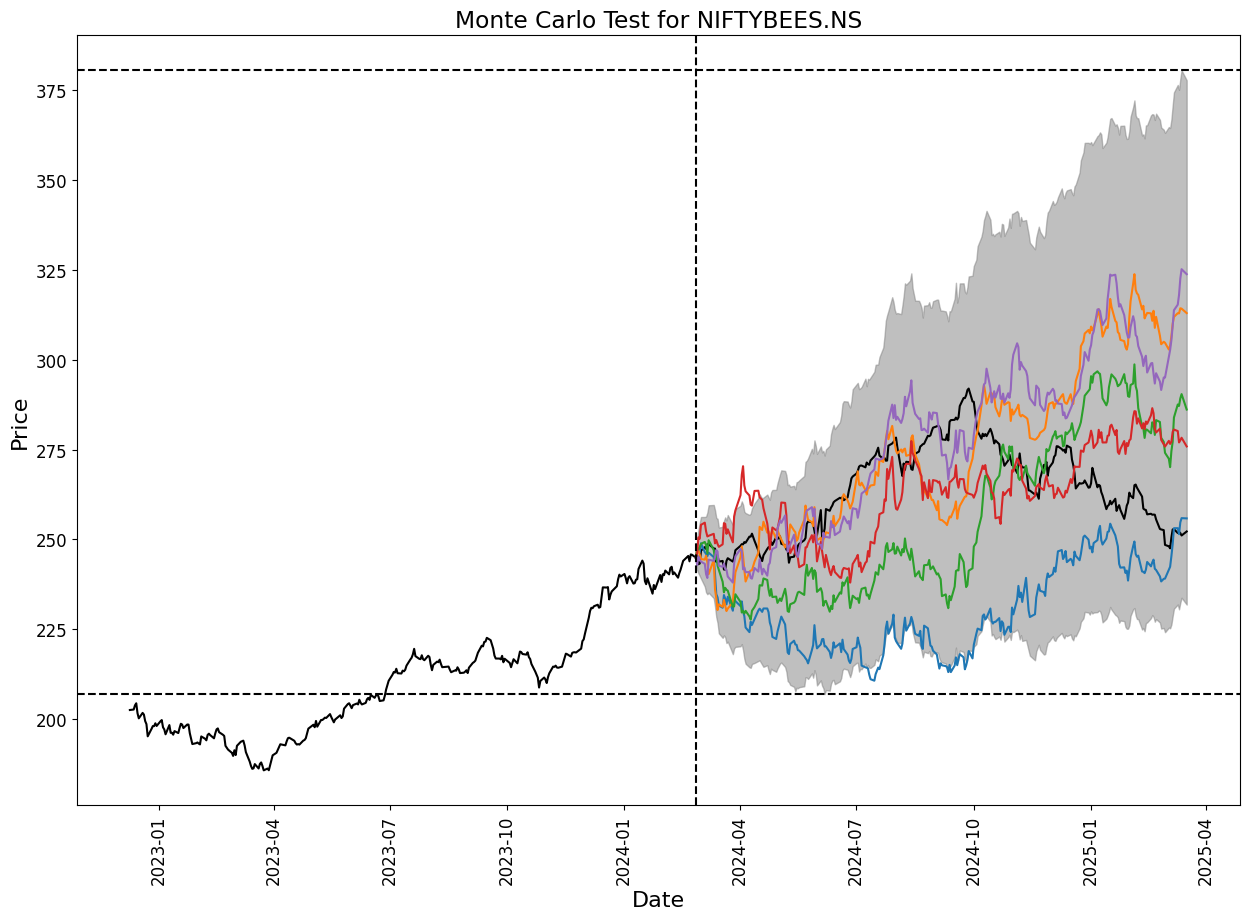

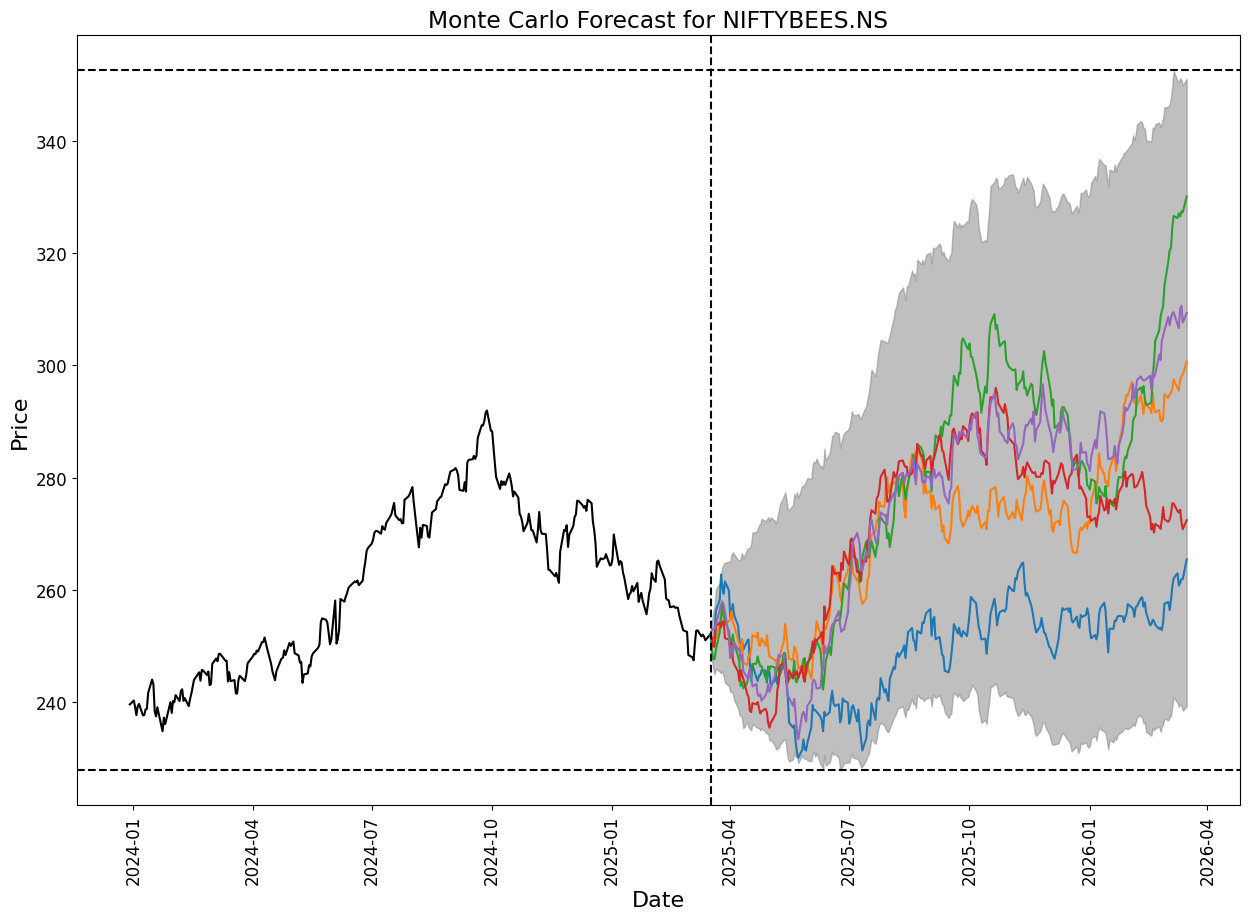

,x_p0,x_p1,x_p2,x_p3,x_p4,x_p5,x_p6,x_p7,x_p8,x_p9,...,x_p250,x_p251,x_p252,x_p253,x_p254,x_p255,x_p256,x_p257,x_p258,x_p259
Intercept,-0.122159,-0.151437,-0.126111,-0.124720,-0.131361,-0.153253,-0.140730,-0.130859,-0.132072,-0.132663,...,0.032718,0.043627,0.042406,0.041775,0.029289,0.030790,0.034391,0.027595,-0.003523,0.004796
x_m1,0.039154,-0.109929,0.021271,0.069425,0.092812,-0.037059,-0.057160,0.022569,-0.055342,-0.101478,...,0.047698,-0.021651,0.045572,0.038015,-0.015685,-0.035886,-0.064413,0.017780,-0.042166,0.016818
x_m2,-0.107481,0.021918,0.065391,0.088828,-0.034587,-0.057391,0.014808,-0.056041,-0.097290,0.064390,...,-0.030692,0.051304,0.031691,-0.016735,-0.032550,-0.060650,0.027040,-0.031539,0.027847,-0.033306
x_m3,0.022831,0.055796,0.094627,-0.026767,-0.054139,0.010423,-0.052057,-0.097288,0.054798,0.006009,...,0.062573,0.024777,-0.005240,-0.026860,-0.063794,0.021590,-0.045749,0.018975,-0.049101,0.053774
x_m4,0.046107,0.103077,-0.031142,-0.053232,0.014364,-0.041858,-0.109613,0.063782,0.012752,0.027274,...,0.025343,-0.000654,-0.039879,-0.075593,0.020925,-0.044774,0.025152,-0.049245,0.077077,-0.008059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x_m297,0.026893,-0.048395,0.115561,0.021797,0.050933,-0.014283,-0.019950,-0.027096,0.089629,0.003781,...,0.049135,0.030844,0.038348,-0.081692,-0.045289,0.052705,-0.056843,-0.036647,-0.016492,0.060479
x_m298,-0.026369,0.116516,0.024221,0.053290,-0.017834,-0.019039,0.001527,0.093521,0.015660,-0.022132,...,0.029936,0.028314,-0.082947,-0.042343,0.040830,-0.064766,-0.031829,-0.009993,0.032971,0.029321
x_m299,0.061629,0.041694,0.049985,-0.015277,-0.018117,0.019579,0.052130,0.024994,-0.033782,0.045674,...,0.046990,-0.071986,-0.051092,0.017299,-0.055033,-0.024802,-0.022708,-0.000179,0.085921,0.075599
x_m300,0.012420,0.063034,-0.016455,-0.024843,0.009058,0.057133,0.011992,-0.038733,0.037643,0.053755,...,-0.067636,-0.044406,0.018126,-0.062627,-0.015117,-0.014518,-0.005723,0.066417,0.097669,0.052026


Long Risk Level for  2026-03-16 05:30:00+05:30  is  227.89009755481976 estimated on  2025-03-17 05:30:00+05:30
Short Risk Level for  2026-03-16 05:30:00+05:30  is  352.49746671844133 estimated on  2025-03-17 05:30:00+05:30
Current Price on  2025-03-17 05:30:00+05:30  is  252.17999267578125


In [17]:
main(ticker)